# CATS: Data Modelling #

### Imports ###

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

### Data Preview ###
Cat data was extracted from the data exported from the Champ_CAT_Transformation notebook.

In [93]:
ctd = pd.read_csv('cat_transformed_data.csv', index_col=0)

In [94]:
print("Total entries: ", len(ctd))
ctd.head()

Total entries:  57350


,Gender_LITTER,Gender_MALE,Gender_UNKNOWN,IntakeInternalStatus_AGG ANIMAL,IntakeInternalStatus_AGG FEAR,IntakeInternalStatus_AGG PEOPLE,IntakeInternalStatus_AGGRESSIVE,IntakeInternalStatus_DEHYDRA,IntakeInternalStatus_DIARRHEA,IntakeInternalStatus_EMACIATED,...,Color_GRAY,Color_ORANGE,Color_OTHER,Color_TORTIE,Color_WHITE,Breed_LONG,Breed_MED,Breed_OTHER,Breed_SHORT,Breed_SIAMESE
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


### Creating Train, Validation, and Test Sets ###
The train, validation, test split was 60/20/20.

In [95]:
X = ctd.drop('LiveOutcome_1', axis = 1)
y = ctd['LiveOutcome_1']

In [102]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

### Using SVM Model as a Baseline ###

In [6]:
svm_clf = svm.SVC()
svm_clf.fit(X_trainval, y_trainval)
svm_clf.score(X_test, y_test)

C:\Users\phoenix.gaylor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8388840453356582

The SVM model, when trained on both the training and validation sets, obtained approximately 84% accuracy, which is an additional 22% over the guessing rate of 62% (all "euthanized"). This means using SVM results in 58% fewer misclassfications than guessing.

### Training a (Shallow) Neural Network ###

#### Converting outcomes to a format interpretable by Keras ####

In [103]:
y_trainval = to_categorical(y_trainval)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#### Developing function that trains and evaluates a Keras model ####

In [63]:
def test_model(d, u, ud, l = 0.2, e = 25, b = 62):
    
    """Given the required parameters, builds a Keras model, fits it to the X_train and y_train sets, 
    and evaluates the model according to the validation set.
    
    Inputs:
        d  - Dropout Rate
        u  - Units in 1st layer
        ud - Units in 2nd layer as the division of u/ud 
        l  - Learning Rate (default: 0.2)
        e  - Number of epochs (default: 25)
        b  - Batch size (default: 62)
        
    Outputs:
        result - An array with the given d, u, ud, and model accuracy on the validation set"""
    
    model = Sequential()

    model.add(Dense(units=u, 
                    activation='relu', 
                    kernel_initializer=keras.initializers.he_normal(seed=1),
                    input_dim=len(X_train.columns)))
    model.add(Dropout(d))
    model.add(Dense(units=int(u/ud), activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(units=2, activation='softmax'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=l),
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=e, batch_size=b, verbose=0)
    print("Validation: ", model.evaluate(X_val, y_val))
    result = [d, u, ud, model.evaluate(X_val, y_val)[1]]

    return result

#### Developing a function that loops through different parameters to determine optimal combination ####

In [9]:
def best_models(d_vals, u_vals, ud_vals, l = 0.2, e = 25, b = 62):
        
    """Loops through each combination of dropout rates and units per layer and runs them through test_model().
    
    Inputs:
        d_vals  - Dropout Rate values
        u_vals  - Units in 1st layer values
        ud_vals - Units in 2nd layer as the division of u/ud values
        l       - Learning Rate (default: 0.2)
        e       - Number of epochs (default: 25)
        b       - Batch size (default: 62)
        
    Outputs:
        result - An matrix with the given d_vals, u_vals, ud_vals, and their model accuracy on the validation set"""
    
    total_models = len(d_vals)*len(u_vals)*len(ud_vals)
    results = np.zeros((total_models,4))
    counter = 0
    
    for drate in d_vals:
        d = drate
    
        for units in u_vals:
            u = units
        
            for unitsd in ud_vals:
                ud = unitsd
                
                print("d =", drate, " u =", units, " ud =", unitsd, " counter =", counter)
                results[counter] = test_model(d = d, u = u, ud = ud)
                counter += 1
                
    return results

#### Running best_models() to find the best Keras models ####
Note: This takes a very long while to run.

In [10]:
d_vals = [0.1, 0.3, 0.5]
u_vals = [64, 128, 256, 512, 1024]
ud_vals = [1.5, 2, 2.5]

model_results = best_models(d_vals, u_vals, ud_vals)
model_results[model_results[:,3] > .855]

d = 0.1  u = 64  ud = 1.5  counter = 0
11470/11470 [==============================] - 0s 19us/step
Validation:  [0.3555576924250868, 0.8493461012840271]
11470/11470 [==============================] - 0s 16us/step
d = 0.1  u = 64  ud = 2  counter = 1
11470/11470 [==============================] - 0s 20us/step
Validation:  [0.35062878081459736, 0.8496948480606079]
11470/11470 [==============================] - 0s 18us/step
d = 0.1  u = 64  ud = 2.5  counter = 2
11470/11470 [==============================] - 0s 20us/step
Validation:  [0.3600967612542998, 0.8501307964324951]
11470/11470 [==============================] - 0s 15us/step
d = 0.1  u = 128  ud = 1.5  counter = 3
11470/11470 [==============================] - 0s 21us/step
Validation:  [0.36214148136149726, 0.8523975610733032]
11470/11470 [==============================] - 0s 17us/step
d = 0.1  u = 128  ud = 2  counter = 4
11470/11470 [==============================] - 0s 20us/step
Validation:  [0.3567584801572452, 0.8488230109214

array([[1.00000000e-01, 5.12000000e+02, 2.00000000e+00, 8.55361819e-01],
       [3.00000000e-01, 5.12000000e+02, 1.50000000e+00, 8.59895408e-01],
       [3.00000000e-01, 5.12000000e+02, 2.00000000e+00, 8.55013072e-01],
       [3.00000000e-01, 1.02400000e+03, 2.50000000e+00, 8.58674824e-01],
       [5.00000000e-01, 1.02400000e+03, 2.00000000e+00, 8.56233656e-01]])

The model that really leads the pack by a fairly significant amount is D=0.3, U=512, U2=1.5, with approximately 86% accuracy.

#### Tuning the best model ####
Behind the scenes, I tried different combinations for learning rate, batch size, and number of epochs.

In [135]:
model = Sequential()

model.add(Dense(units=512, 
                activation='relu', 
                kernel_initializer=keras.initializers.he_normal(seed=1),
                input_dim=len(X_train.columns)))
model.add(Dropout(0.5))
model.add(Dense(units=int(512/1.5), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss=keras.losses.binary_crossentropy,
                optimizer=keras.optimizers.SGD(learning_rate=0.1),
                metrics=['accuracy'])

history = model.fit(X_trainval, y_trainval, epochs=50, batch_size=80, verbose=1, validation_data = [X_test, y_test])
print("Test: ", model.evaluate(X_test, y_test))

Train on 45880 samples, validate on 11470 samples
Epoch 1/50
45880/45880 [==============================] - 3s 64us/step - loss: 0.4878 - accuracy: 0.7661 - val_loss: 0.3887 - val_accuracy: 0.8317
Epoch 2/50
45880/45880 [==============================] - 3s 59us/step - loss: 0.4241 - accuracy: 0.8086 - val_loss: 0.3712 - val_accuracy: 0.8364
Epoch 3/50
45880/45880 [==============================] - 2s 46us/step - loss: 0.4097 - accuracy: 0.8155 - val_loss: 0.3709 - val_accuracy: 0.8402
Epoch 4/50
45880/45880 [==============================] - 3s 60us/step - loss: 0.3998 - accuracy: 0.8226 - val_loss: 0.3605 - val_accuracy: 0.8418
Epoch 5/50
45880/45880 [==============================] - 4s 97us/step - loss: 0.3934 - accuracy: 0.8259 - val_loss: 0.3597 - val_accuracy: 0.8400
Epoch 6/50
45880/45880 [==============================] - 3s 56us/step - loss: 0.3873 - accuracy: 0.8279 - val_loss: 0.3607 - val_accuracy: 0.8434
Epoch 7/50
45880/45880 [==============================] - 2s 54us/st

The model performs very well on the test set, just shy of 86% accuracy. This is about 2% better than the SVM model with 12% fewer misclassifications.

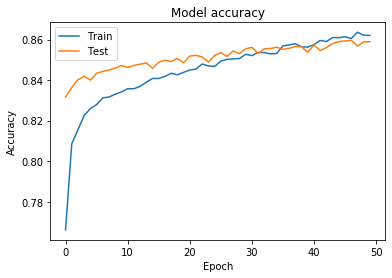

In [136]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The model tends to do pretty well and does not severely overfit.

### Saving the Model ###

In [137]:
model.save("cat_model.h5")